In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install torchinfo

In [3]:
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import shutil
import torch
from torch import nn
from torchinfo import summary
import cv2
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import albumentations as A
import cv2
import zipfile
from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt
from time import perf_counter as timer
import math
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from typing import Callable, Tuple, Optional, Dict, Any
import matplotlib.pyplot as plt


import numpy as np
import torch
import torch.nn as nn
from typing import Dict, Any, List, Tuple, Optional
import random
from sklearn.model_selection import ParameterSampler
from scipy.stats import uniform, loguniform, randint
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import json

In [5]:
# Your existing data loading code:
train_data_path = "/content/drive/MyDrive/Metal Detection Data/Processed_Data/train"
valid_data_path = "/content/drive/MyDrive/Metal Detection Data/Processed_Data/valid"
test_data_path = "/content/drive/MyDrive/Metal Detection Data/Processed_Data/test"

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_data = datasets.ImageFolder(train_data_path, transform=transform)
valid_data = datasets.ImageFolder(valid_data_path, transform=transform)
test_data = datasets.ImageFolder(test_data_path, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes
class_dict = train_data.class_to_idx

In [6]:
class TinyVGG_v2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 64 * 64, out_features=output_shape),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x



device = 'cuda' if torch.cuda.is_available() else 'cpu'


model = TinyVGG_v2(
    input_shape=3,
    hidden_units=64,
    output_shape=len(class_names)
).to(device)

print(f"Fixed model parameters: {sum(p.numel() for p in model.parameters())}")

Fixed model parameters: 1685446


In [7]:
class ParticleSwarmOptimizer:
    """
    Particle Swarm Optimization implementation for hyperparameter tuning
    """
    def __init__(self,
                 objective_function,
                 dimension,
                 population_size=20,
                 max_iterations=50,
                 bounds=(0, 1),
                 w=0.7,           # Inertia weight
                 c1=1.5,          # Cognitive coefficient
                 c2=1.5,          # Social coefficient
                 random_seed=None):

        self.objective_function = objective_function
        self.dimension = dimension
        self.population_size = population_size
        self.max_iterations = max_iterations
        self.bounds = bounds
        self.w = w
        self.c1 = c1
        self.c2 = c2

        if random_seed is not None:
            np.random.seed(random_seed)
            random.seed(random_seed)
            torch.manual_seed(random_seed)

        # Initialize particles
        self.particles_position = np.random.uniform(bounds[0], bounds[1],
                                                   (population_size, dimension))
        self.particles_velocity = np.random.uniform(-1, 1, (population_size, dimension))

        # Initialize personal best positions and fitness
        self.personal_best_positions = self.particles_position.copy()
        self.personal_best_fitness = np.full(population_size, np.inf)

        # Initialize global best
        self.global_best_position = None
        self.global_best_fitness = np.inf

        self.convergence_history = []

    def update_velocity(self, iteration):
        """Update particle velocities using PSO formula"""
        # Adaptive inertia weight (decreases over iterations)
        w_adaptive = self.w * (1 - iteration / self.max_iterations)

        for i in range(self.population_size):
            # Random components
            r1 = np.random.random(self.dimension)
            r2 = np.random.random(self.dimension)

            # Cognitive component (personal best)
            cognitive = self.c1 * r1 * (self.personal_best_positions[i] - self.particles_position[i])

            # Social component (global best)
            social = self.c2 * r2 * (self.global_best_position - self.particles_position[i])

            # Update velocity
            self.particles_velocity[i] = (w_adaptive * self.particles_velocity[i] +
                                        cognitive + social)

            # Velocity clamping to prevent explosion
            max_velocity = (self.bounds[1] - self.bounds[0]) * 0.1
            self.particles_velocity[i] = np.clip(self.particles_velocity[i],
                                               -max_velocity, max_velocity)

    def update_position(self):
        """Update particle positions"""
        self.particles_position += self.particles_velocity

        # Ensure particles stay within bounds
        self.particles_position = np.clip(self.particles_position,
                                        self.bounds[0], self.bounds[1])

    def evaluate_fitness(self):
        """Evaluate fitness for all particles"""
        for i in range(self.population_size):
            fitness = self.objective_function(self.particles_position[i])

            # Update personal best
            if fitness < self.personal_best_fitness[i]:
                self.personal_best_fitness[i] = fitness
                self.personal_best_positions[i] = self.particles_position[i].copy()

            # Update global best
            if fitness < self.global_best_fitness:
                self.global_best_fitness = fitness
                self.global_best_position = self.particles_position[i].copy()

    def optimize(self, verbose=True):
        """Run PSO optimization"""
        if verbose:
            print("Starting PSO optimization...")
            print(f"Population size: {self.population_size}")
            print(f"Dimensions: {self.dimension}")
            print(f"Max iterations: {self.max_iterations}")
            print("-" * 50)

        # Initial evaluation
        self.evaluate_fitness()
        self.convergence_history.append(self.global_best_fitness)

        if verbose:
            print(f"Initial best fitness: {self.global_best_fitness:.6f}")

        # Main optimization loop
        for iteration in range(self.max_iterations):
            # Update velocities and positions
            self.update_velocity(iteration)
            self.update_position()

            # Evaluate fitness
            self.evaluate_fitness()
            self.convergence_history.append(self.global_best_fitness)

            if verbose and (iteration + 1) % 5 == 0:
                print(f"Iteration {iteration + 1:3d}: Best fitness = {self.global_best_fitness:.6f}")

        if verbose:
            print("-" * 50)
            print(f"Optimization completed!")
            print(f"Best fitness: {self.global_best_fitness:.6f}")

        return {
            'best_position': self.global_best_position,
            'best_fitness': self.global_best_fitness,
            'convergence_history': self.convergence_history
        }


In [8]:
class PSO_CNN_Trainer:
    """CNN Trainer with Particle Swarm Optimization"""

    def __init__(self,
                 train_loader,
                 valid_loader,
                 test_loader,
                 num_classes,
                 device='cuda' if torch.cuda.is_available() else 'cpu'):

        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader
        self.num_classes = num_classes
        self.device = device

        # Parameter bounds for PSO optimization
        self.param_bounds = {
            'learning_rate': (1e-5, 1e-1),    # log scale
            'hidden_units': (8, 128),         # linear scale
            'dropout_rate': (0.0, 0.7),       # linear scale
            'weight_decay': (1e-6, 1e-2)      # log scale
        }

    def vector_to_params(self, vector):
        """Convert PSO vector to CNN parameters"""
        params = {}

        # Learning rate (log scale)
        params['learning_rate'] = 10 ** (vector[0] * (np.log10(self.param_bounds['learning_rate'][1]) -
                                                      np.log10(self.param_bounds['learning_rate'][0])) +
                                        np.log10(self.param_bounds['learning_rate'][0]))

        # Hidden units (linear scale)
        params['hidden_units'] = int(vector[1] * (self.param_bounds['hidden_units'][1] -
                                                 self.param_bounds['hidden_units'][0]) +
                                    self.param_bounds['hidden_units'][0])

        # Dropout rate (linear scale)
        params['dropout_rate'] = vector[2] * (self.param_bounds['dropout_rate'][1] -
                                             self.param_bounds['dropout_rate'][0]) + \
                                self.param_bounds['dropout_rate'][0]

        # Weight decay (log scale)
        params['weight_decay'] = 10 ** (vector[3] * (np.log10(self.param_bounds['weight_decay'][1]) -
                                                     np.log10(self.param_bounds['weight_decay'][0])) +
                                       np.log10(self.param_bounds['weight_decay'][0]))

        return params

    def create_model_with_dropout(self, hidden_units, dropout_rate):
        """Create TinyVGG model with dropout"""
        model = TinyVGG_v2(input_shape=3,
                          hidden_units=hidden_units,
                          output_shape=self.num_classes)

        # Replace classifier with dropout
        model.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(in_features=hidden_units * 64 * 64, out_features=self.num_classes),
        )

        return model.to(self.device)

    def train_and_evaluate(self, params, epochs=10):
        """Train CNN with given parameters and return validation loss"""
        # Create model with dropout
        model = self.create_model_with_dropout(params['hidden_units'], params['dropout_rate'])

        # Setup training
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(),
                                   lr=params['learning_rate'],
                                   weight_decay=params['weight_decay'])

        # Training loop
        model.train()
        for epoch in range(epochs):
            for batch_idx, (data, target) in enumerate(self.train_loader):
                if batch_idx > 25:  # Limit training for faster PSO iterations
                    break

                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in self.valid_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = model(data)
                val_loss += criterion(output, target).item()
                pred = output.argmax(dim=1)
                val_correct += pred.eq(target).sum().item()
                val_total += target.size(0)

        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(self.valid_loader)

        # Return fitness (what PSO minimizes) with penalty for low accuracy
        fitness = avg_val_loss + (1 - val_accuracy) * 0.3
        return fitness, model, val_accuracy

    def objective_function(self, vector):
        """Objective function for PSO"""
        # Ensure vector is in bounds [0, 1]
        vector = np.clip(vector, 0, 1)
        params = self.vector_to_params(vector)
        fitness, _, _ = self.train_and_evaluate(params, epochs=5)  # Short training for PSO
        return fitness

    def run_optimization(self,
                        population_size=15,
                        max_iterations=25,
                        w=0.7,
                        c1=1.5,
                        c2=1.5,
                        verbose=True):
        """Run PSO optimization"""

        pso = ParticleSwarmOptimizer(
            objective_function=self.objective_function,
            dimension=4,  # 4 parameters to optimize
            population_size=population_size,
            max_iterations=max_iterations,
            bounds=(0, 1),  # Normalized bounds
            w=w,
            c1=c1,
            c2=c2,
            random_seed=42
        )

        result = pso.optimize(verbose=verbose)

        # Get best parameters
        best_params = self.vector_to_params(result['best_position'])

        # Train final model with best parameters
        print("\nTraining final model with best parameters...")
        print(f"Best parameters: {best_params}")

        final_fitness, final_model, final_accuracy = self.train_and_evaluate(
            best_params, epochs=25
        )

        return {
            'best_params': best_params,
            'final_model': final_model,
            'final_accuracy': final_accuracy,
            'convergence_history': result['convergence_history']
        }

    def test_model(self, model):
        """Test the final model"""
        model.eval()
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = model(data)
                pred = output.argmax(dim=1)
                test_correct += pred.eq(target).sum().item()
                test_total += target.size(0)

        test_accuracy = test_correct / test_total
        print(f"Test Accuracy: {test_accuracy:.4f}")
        return test_accuracy


In [9]:
def run_pso_training(train_loader, valid_loader, test_loader, num_classes,
                     population_size=15, max_iterations=25, w=0.7, c1=1.5, c2=1.5):
    """Main function to run PSO training"""

    # Initialize trainer
    trainer = PSO_CNN_Trainer(
        train_loader=train_loader,
        valid_loader=valid_loader,
        test_loader=test_loader,
        num_classes=num_classes
    )

    # Run optimization
    result = trainer.run_optimization(
        population_size=population_size,
        max_iterations=max_iterations,
        w=w,
        c1=c1,
        c2=c2,
        verbose=True
    )

    # Test final model
    test_accuracy = trainer.test_model(result['final_model'])

    # Plot convergence
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(result['convergence_history'], 'r-', linewidth=2, marker='o', markersize=4)
    plt.title('PSO Convergence Curve')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness (Validation Loss + Penalty)')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    # Plot last 10 iterations for detail
    if len(result['convergence_history']) > 10:
        plt.plot(range(len(result['convergence_history'])-10, len(result['convergence_history'])),
                result['convergence_history'][-10:], 'r-', linewidth=2, marker='o', markersize=6)
        plt.title('PSO Convergence (Last 10 Iterations)')
        plt.xlabel('Iteration')
        plt.ylabel('Fitness')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return result, test_accuracy

In [10]:
# result, test_acc = run_pso_training(
#     train_loader, valid_loader, test_loader,
#     num_classes=len(class_names),
#     population_size=15,
#     max_iterations=25,
#     w=0.7,    # Inertia weight
#     c1=1.5,   # Cognitive coefficient
#     c2=1.5    # Social coefficient
# )

# print(f"Final test accuracy: {test_acc:.4f}")
# print(f"Best parameters found: {result['best_params']}")

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda



STARTING PSO HYPERPARAMETER OPTIMIZATION

1. Running Standard PSO Configuration...
Starting PSO optimization...
Population size: 12
Dimensions: 4
Max iterations: 10
--------------------------------------------------
Initial best fitness: 0.070645
Iteration   5: Best fitness = 0.070645
Iteration  10: Best fitness = 0.061517
--------------------------------------------------
Optimization completed!
Best fitness: 0.061517

Training final model with best parameters...
Best parameters: {'learning_rate': np.float64(0.00047124964957375706), 'hidden_units': 122, 'dropout_rate': np.float64(0.5239521119524159), 'weight_decay': np.float64(0.00021839815128434108)}
Test Accuracy: 0.8056


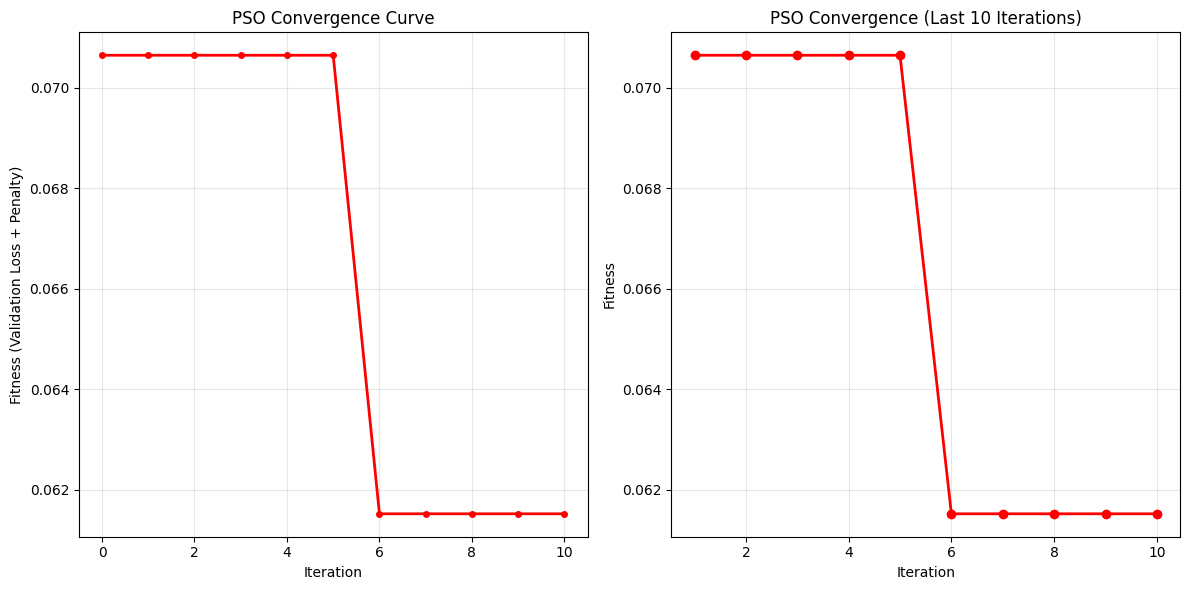


Standard PSO Results:
Final test accuracy: 0.8056
Best parameters: {'learning_rate': np.float64(0.00047124964957375706), 'hidden_units': 122, 'dropout_rate': np.float64(0.5239521119524159), 'weight_decay': np.float64(0.00021839815128434108)}


In [12]:
print("\n" + "="*60)
print("STARTING PSO HYPERPARAMETER OPTIMIZATION")
print("="*60)

# Configuration 1: Standard PSO
print("\n1. Running Standard PSO Configuration...")
result_standard, test_acc_standard = run_pso_training(
    train_loader, valid_loader, test_loader,
    num_classes=len(class_names),
    population_size=12,
    max_iterations=10,
    w=0.7,    # Standard inertia weight
    c1=1.5,   # Cognitive coefficient
    c2=1.5    # Social coefficient
)

print(f"\nStandard PSO Results:")
print(f"Final test accuracy: {test_acc_standard:.4f}")
print(f"Best parameters: {result_standard['best_params']}")

In [ ]:
# Configuration 2: Exploration-focused PSO
print("\n2. Running Exploration-focused PSO Configuration...")
result_exploration, test_acc_exploration = run_pso_training(
    train_loader, valid_loader, test_loader,
    num_classes=len(class_names),
    population_size=15,
    max_iterations=25,
    w=0.9,    # Higher inertia for more exploration
    c1=2.0,   # Higher cognitive coefficient
    c2=1.0    # Lower social coefficient
)

print(f"\nExploration-focused PSO Results:")
print(f"Final test accuracy: {test_acc_exploration:.4f}")
print(f"Best parameters: {result_exploration['best_params']}")

In [ ]:
# Configuration 3: Exploitation-focused PSO
print("\n3. Running Exploitation-focused PSO Configuration...")
result_exploitation, test_acc_exploitation = run_pso_training(
    train_loader, valid_loader, test_loader,
    num_classes=len(class_names),
    population_size=10,
    max_iterations=30,
    w=0.4,    # Lower inertia for more exploitation
    c1=1.0,   # Lower cognitive coefficient
    c2=2.0    # Higher social coefficient
)

print(f"\nExploitation-focused PSO Results:")
print(f"Final test accuracy: {test_acc_exploitation:.4f}")
print(f"Best parameters: {result_exploitation['best_params']}")

In [ ]:
# Compare results
print("\n" + "="*60)
print("COMPARISON OF PSO CONFIGURATIONS")
print("="*60)

results_comparison = [
    ("Standard PSO", test_acc_standard, result_standard['best_params']),
    ("Exploration PSO", test_acc_exploration, result_exploration['best_params']),
    ("Exploitation PSO", test_acc_exploitation, result_exploitation['best_params'])
]

results_comparison.sort(key=lambda x: x[1], reverse=True)

for i, (config_name, accuracy, params) in enumerate(results_comparison):
    print(f"{i+1}. {config_name}")
    print(f"   Test Accuracy: {accuracy:.4f}")
    print(f"   Learning Rate: {params['learning_rate']:.6f}")
    print(f"   Hidden Units: {params['hidden_units']}")
    print(f"   Dropout Rate: {params['dropout_rate']:.3f}")
    print(f"   Weight Decay: {params['weight_decay']:.6f}")
    print()

# Plot comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(result_standard['convergence_history'], 'b-', linewidth=2, label='Standard PSO')
plt.plot(result_exploration['convergence_history'], 'r-', linewidth=2, label='Exploration PSO')
plt.plot(result_exploitation['convergence_history'], 'g-', linewidth=2, label='Exploitation PSO')
plt.title('PSO Convergence Comparison')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
configs = ['Standard', 'Exploration', 'Exploitation']
accuracies = [test_acc_standard, test_acc_exploration, test_acc_exploitation]
colors = ['blue', 'red', 'green']
bars = plt.bar(configs, accuracies, color=colors, alpha=0.7)
plt.title('Test Accuracy Comparison')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

plt.subplot(1, 3, 3)
# Compare hyperparameters
param_names = ['Learning Rate', 'Hidden Units', 'Dropout Rate', 'Weight Decay']
standard_params = [result_standard['best_params']['learning_rate'],
                   result_standard['best_params']['hidden_units'],
                   result_standard['best_params']['dropout_rate'],
                   result_standard['best_params']['weight_decay']]

exploration_params = [result_exploration['best_params']['learning_rate'],
                      result_exploration['best_params']['hidden_units'],
                      result_exploration['best_params']['dropout_rate'],
                      result_exploration['best_params']['weight_decay']]

exploitation_params = [result_exploitation['best_params']['learning_rate'],
                       result_exploitation['best_params']['hidden_units'],
                       result_exploitation['best_params']['dropout_rate'],
                       result_exploitation['best_params']['weight_decay']]

# Normalize for comparison (log scale for learning rate and weight decay)
x = np.arange(len(param_names))
width = 0.25

plt.bar(x - width, [np.log10(standard_params[0]), standard_params[1]/100,
                    standard_params[2], np.log10(standard_params[3])],
        width, label='Standard', alpha=0.7)
plt.bar(x, [np.log10(exploration_params[0]), exploration_params[1]/100,
            exploration_params[2], np.log10(exploration_params[3])],
        width, label='Exploration', alpha=0.7)
plt.bar(x + width, [np.log10(exploitation_params[0]), exploitation_params[1]/100,
                    exploitation_params[2], np.log10(exploitation_params[3])],
        width, label='Exploitation', alpha=0.7)

plt.title('Best Hyperparameters Comparison\n(Normalized Scale)')
plt.xlabel('Parameters')
plt.ylabel('Normalized Values')
plt.xticks(x, ['log(LR)', 'HU/100', 'Dropout', 'log(WD)'])
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nBest overall configuration: {results_comparison[0][0]}")
print(f"Best test accuracy achieved: {results_comparison[0][1]:.4f}")

In [13]:
def get_training_accuracy(model, train_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Evaluate the trained model on training data to get training accuracy

    Args:
        model: Your trained TinyVGG model
        train_loader: Your training data loader
        device: Device to run evaluation on

    Returns:
        training_accuracy: Accuracy on training set
    """
    model.eval()  # Set model to evaluation mode
    train_correct = 0
    train_total = 0

    print("Evaluating model on training data...")

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            train_correct += pred.eq(target).sum().item()
            train_total += target.size(0)

            # Print progress every 50 batches
            if (batch_idx + 1) % 50 == 0:
                current_acc = train_correct / train_total
                print(f"Batch {batch_idx + 1}: Current Training Accuracy = {current_acc:.4f}")

    training_accuracy = train_correct / train_total
    print(f"\nFinal Training Accuracy: {training_accuracy:.4f}")
    return training_accuracy

def get_validation_accuracy(model, valid_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Evaluate the trained model on validation data to get validation accuracy

    Args:
        model: Your trained TinyVGG model
        valid_loader: Your validation data loader
        device: Device to run evaluation on

    Returns:
        validation_accuracy: Accuracy on validation set
    """
    model.eval()
    valid_correct = 0
    valid_total = 0

    print("Evaluating model on validation data...")

    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            valid_correct += pred.eq(target).sum().item()
            valid_total += target.size(0)

    validation_accuracy = valid_correct / valid_total
    print(f"Validation Accuracy: {validation_accuracy:.4f}")
    return validation_accuracy

def get_all_accuracies(model, train_loader, valid_loader, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Get training, validation, and test accuracies from your trained model

    Args:
        model: Your trained TinyVGG model
        train_loader: Training data loader
        valid_loader: Validation data loader
        test_loader: Test data loader
        device: Device to run evaluation on

    Returns:
        dict: Dictionary with all accuracies
    """
    print("="*60)
    print("EVALUATING TRAINED MODEL ON ALL DATASETS")
    print("="*60)

    # Get training accuracy
    train_acc = get_training_accuracy(model, train_loader, device)
    print("-" * 40)

    # Get validation accuracy
    valid_acc = get_validation_accuracy(model, valid_loader, device)
    print("-" * 40)

    # Get test accuracy (you already have this, but for completeness)
    model.eval()
    test_correct = 0
    test_total = 0

    print("Evaluating model on test data...")
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            test_correct += pred.eq(target).sum().item()
            test_total += target.size(0)

    test_acc = test_correct / test_total
    print(f"Test Accuracy: {test_acc:.4f}")

    print("="*60)
    print("SUMMARY OF ALL ACCURACIES")
    print("="*60)
    print(f"Training Accuracy:   {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"Validation Accuracy: {valid_acc:.4f} ({valid_acc*100:.2f}%)")
    print(f"Test Accuracy:       {test_acc:.4f} ({test_acc*100:.2f}%)")
    print("="*60)

    return {
        'training_accuracy': train_acc,
        'validation_accuracy': valid_acc,
        'test_accuracy': test_acc
    }



In [14]:
# Since you have the result from your GOA training:
final_model = result_standard['final_model']

# Get all accuracies
all_accuracies = get_all_accuracies(
    model=final_model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader
)

# Or just get training accuracy:
training_acc = get_training_accuracy(final_model, train_loader)

EVALUATING TRAINED MODEL ON ALL DATASETS
Evaluating model on training data...
Batch 50: Current Training Accuracy = 0.9794

Final Training Accuracy: 0.9778
----------------------------------------
Evaluating model on validation data...
Validation Accuracy: 0.9167
----------------------------------------
Evaluating model on test data...
Test Accuracy: 0.8056
SUMMARY OF ALL ACCURACIES
Training Accuracy:   0.9778 (97.78%)
Validation Accuracy: 0.9167 (91.67%)
Test Accuracy:       0.8056 (80.56%)
Evaluating model on training data...
Batch 50: Current Training Accuracy = 0.9788

Final Training Accuracy: 0.9778


## Saving

In [18]:
import torch
import pickle
import json
from google.colab import files
import os

def save_and_download_model(model, best_params, all_accuracies=None, save_name="standard_pso_tinyvgg_model"):
    """
    Save and download your trained model with all related information

    Args:
        model: Your trained TinyVGG model
        best_params: Dictionary with best parameters found by GOA
        all_accuracies: Dictionary with training/validation/test accuracies
        save_name: Base name for saved files
    """

    print("Saving trained model and parameters...")

    # 1. Save the complete model (architecture + weights)
    model_path = f"{save_name}_complete.pth"
    torch.save(model, model_path)
    print(f"✓ Complete model saved as: {model_path}")

    # 2. Save only the model weights (smaller file, need architecture to load)
    weights_path = f"{save_name}_weights.pth"
    torch.save(model.state_dict(), weights_path)
    print(f"✓ Model weights saved as: {weights_path}")

    # 3. Save best parameters and model info
    model_info = {
        'best_parameters': best_params,
        'model_architecture': 'TinyVGG',
        'input_shape': 3,
        'hidden_units': best_params['hidden_units'],
        'output_shape': model.classifier[-1].out_features,
        'accuracies': all_accuracies if all_accuracies else {},
        'optimizer_used': 'Gazelle Optimization Algorithm (GOA)'
    }

    # Save as JSON
    json_path = f"{save_name}_info.json"
    with open(json_path, 'w') as f:
        # Convert numpy types to regular Python types for JSON serialization
        json_model_info = {}
        for key, value in model_info.items():
            if isinstance(value, dict):
                json_model_info[key] = {k: float(v) if hasattr(v, 'item') else v for k, v in value.items()}
            else:
                json_model_info[key] = float(value) if hasattr(value, 'item') else value
        json.dump(json_model_info, f, indent=4)
    print(f"✓ Model info saved as: {json_path}")

    # 4. Save as pickle (includes everything)
    pickle_path = f"{save_name}_complete.pkl"
    with open(pickle_path, 'wb') as f:
        pickle.dump({
            'model': model,
            'parameters': best_params,
            'accuracies': all_accuracies,
            'model_info': model_info
        }, f)
    print(f"✓ Complete pickle file saved as: {pickle_path}")

    print("\n" + "="*50)
    print("DOWNLOADING FILES...")
    print("="*50)

    try:
        # Download all files
        files.download(model_path)
        print(f"✓ Downloaded: {model_path}")

        files.download(weights_path)
        print(f"✓ Downloaded: {weights_path}")

        files.download(json_path)
        print(f"✓ Downloaded: {json_path}")

        files.download(pickle_path)
        print(f"✓ Downloaded: {pickle_path}")

        print("\n✅ All files downloaded successfully!")

    except Exception as e:
        print(f"❌ Download error: {e}")
        print("Files are saved in Colab. You can download them manually from the file browser.")

def load_model_guide():
    """
    Print guide on how to load the downloaded model
    """
    guide = """
    📖 HOW TO LOAD YOUR DOWNLOADED MODEL:

    Method 1 - Load Complete Model (Easiest):
    ----------------------------------------
    import torch

    # Load the complete model
    model = torch.load('goa_tinyvgg_model_complete.pth')
    model.eval()  # Set to evaluation mode

    Method 2 - Load Weights Only:
    ----------------------------
    import torch
    import torch.nn as nn

    # First recreate the model architecture
    class TinyVGG(nn.Module):
        # ... (your TinyVGG class definition)

    # Create model instance with same parameters
    model = TinyVGG(input_shape=3, hidden_units=90, output_shape=2)

    # Load the weights
    model.load_state_dict(torch.load('goa_tinyvgg_model_weights.pth'))
    model.eval()

    Method 3 - Load from Pickle:
    ---------------------------
    import pickle

    with open('goa_tinyvgg_model_complete.pkl', 'rb') as f:
        saved_data = pickle.load(f)

    model = saved_data['model']
    parameters = saved_data['parameters']
    accuracies = saved_data['accuracies']

    Method 4 - Load Model Info:
    --------------------------
    import json

    with open('goa_tinyvgg_model_info.json', 'r') as f:
        model_info = json.load(f)

    print("Best Parameters:", model_info['best_parameters'])
    print("Accuracies:", model_info['accuracies'])
    """

    print(guide)

def quick_save_to_drive(model, best_params, all_accuracies=None):
    """
    Quick save to Google Drive (if mounted)
    """
    drive_path = "/content/drive/MyDrive/Metal Detection Data/results/standard_pso/"

    if os.path.exists(drive_path):
        print("Saving to Google Drive...")

        # Save to drive
        model_path = f"{drive_path}standard_pso_tinyvgg_model.pth"
        torch.save(model, model_path)

        # Save parameters
        info_path = f"{drive_path}pso_model_info.json"
        model_info = {
            'best_parameters': {k: float(v) if hasattr(v, 'item') else v for k, v in best_params.items()},
            'accuracies': {k: float(v) if hasattr(v, 'item') else v for k, v in (all_accuracies or {}).items()},
            'model_type': 'TinyVGG optimized with GOA'
        }

        with open(info_path, 'w') as f:
            json.dump(model_info, f, indent=4)

        print(f"✅ Model saved to Google Drive:")
        print(f"   - Model: {model_path}")
        print(f"   - Info: {info_path}")
    else:
        print("❌ Google Drive not mounted. Use save_and_download_model() instead.")

# Usage with your trained model:
"""
# Get your trained model and parameters
final_model = result['final_model']
best_params = result['best_params']

# Optional: Get all accuracies first
all_accuracies = get_all_accuracies(final_model, train_loader, valid_loader, test_loader)

# Method 1: Download to local computer
save_and_download_model(
    model=final_model,
    best_params=best_params,
    all_accuracies=all_accuracies,
    save_name="my_goa_tinyvgg"
)

# Method 2: Save to Google Drive (if mounted)
quick_save_to_drive(final_model, best_params, all_accuracies)

# Show loading guide
load_model_guide()
"""

'\n# Get your trained model and parameters\nfinal_model = result[\'final_model\']\nbest_params = result[\'best_params\']\n\n# Optional: Get all accuracies first\nall_accuracies = get_all_accuracies(final_model, train_loader, valid_loader, test_loader)\n\n# Method 1: Download to local computer\nsave_and_download_model(\n    model=final_model,\n    best_params=best_params,\n    all_accuracies=all_accuracies,\n    save_name="my_goa_tinyvgg"\n)\n\n# Method 2: Save to Google Drive (if mounted)\nquick_save_to_drive(final_model, best_params, all_accuracies)\n\n# Show loading guide\nload_model_guide()\n'

In [16]:
# Get your trained model and parameters
final_model = result_standard['final_model']
best_params = result_standard['best_params']

# Optional: Get accuracies if you want them saved too
all_accuracies = get_all_accuracies(final_model, train_loader, valid_loader, test_loader)

# Download the model to your local computer
save_and_download_model(
    model=final_model,
    best_params=best_params,
    all_accuracies=all_accuracies,
    save_name="standard_pso_tinyvgg_model"
)

# Show guide on how to load the model later
load_model_guide()

EVALUATING TRAINED MODEL ON ALL DATASETS
Evaluating model on training data...
Batch 50: Current Training Accuracy = 0.9775

Final Training Accuracy: 0.9778
----------------------------------------
Evaluating model on validation data...
Validation Accuracy: 0.9167
----------------------------------------
Evaluating model on test data...
Test Accuracy: 0.8056
SUMMARY OF ALL ACCURACIES
Training Accuracy:   0.9778 (97.78%)
Validation Accuracy: 0.9167 (91.67%)
Test Accuracy:       0.8056 (80.56%)
Saving trained model and parameters...
✓ Complete model saved as: standard_pso_tinyvgg_model_complete.pth
✓ Model weights saved as: standard_pso_tinyvgg_model_weights.pth
✓ Model info saved as: standard_pso_tinyvgg_model_info.json
✓ Complete pickle file saved as: standard_pso_tinyvgg_model_complete.pkl

DOWNLOADING FILES...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: standard_pso_tinyvgg_model_complete.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: standard_pso_tinyvgg_model_weights.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: standard_pso_tinyvgg_model_info.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: standard_pso_tinyvgg_model_complete.pkl

✅ All files downloaded successfully!

    📖 HOW TO LOAD YOUR DOWNLOADED MODEL:

    Method 1 - Load Complete Model (Easiest):
    ----------------------------------------
    import torch

    # Load the complete model
    model = torch.load('goa_tinyvgg_model_complete.pth')
    model.eval()  # Set to evaluation mode

    Method 2 - Load Weights Only:
    ----------------------------
    import torch
    import torch.nn as nn

    # First recreate the model architecture
    class TinyVGG(nn.Module):
        # ... (your TinyVGG class definition)

    # Create model instance with same parameters
    model = TinyVGG(input_shape=3, hidden_units=90, output_shape=2)

    # Load the weights
    model.load_state_dict(torch.load('goa_tinyvgg_model_weights.pth'))
    model.eval()

    Method 3 - Load from Pickle:
    ---------------------------
    import pickle

    with open('goa_tinyvgg_model_complete.pkl', 'rb') as f:
        saved_data 

In [19]:
quick_save_to_drive(final_model, best_params, all_accuracies)

Saving to Google Drive...
✅ Model saved to Google Drive:
   - Model: /content/drive/MyDrive/Metal Detection Data/results/standard_pso/standard_pso_tinyvgg_model.pth
   - Info: /content/drive/MyDrive/Metal Detection Data/results/standard_pso/pso_model_info.json
